In [1]:
# %pip install nltk
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib
# %pip install tensorflow

In [2]:
import re
import nltk
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Activation, Embedding, Bidirectional, SpatialDropout1D

In [3]:
# nltk.download('stopwords')

In [4]:
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

In [5]:
MIN_WORD_P_ENTRY = 1

TEST_SIZE = 0.25
VALIDATION_SIZE = 0.15

MAX_SEQUENCE_LENGTH = 200
TRUNC_TYPE= 'post'
PADDING_TYPE = 'post'

OOV_TOK= '<OOV>'

EMBEDDING_DIM = 100
LR = 0.001
DECAY = 1e-6

In [6]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime2.xlsx")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68934 entries, 0 to 68933
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   68934 non-null  object
 1   Label   68934 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None


In [7]:
print(train_df.describe())

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title  Label
count                                               68934  68934
unique                                              68393      2
top     Johnny Depp’s agent says Amber Heard’s op-ed p...  Crime
freq                                                    2  35334
All entries unique: False
Null cells: 0


In [8]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')
train_df = train_df[train_df['Title'].map(len)>0]
train_df.dropna()

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

All entries unique: True
Null cells: 0


In [9]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count', 'label_name'])

filtered_df['label_name'] = pd.Series(pd.Categorical(train_df['Label']))
filtered_df['label'] = (pd.Categorical(filtered_df['label_name']).codes).astype(int)
label_ids = dict(enumerate(filtered_df['label_name'].cat.categories))

print("Label IDs")
print(label_ids)

Label IDs
{0: 'Crime', 1: 'Non-Crime'}


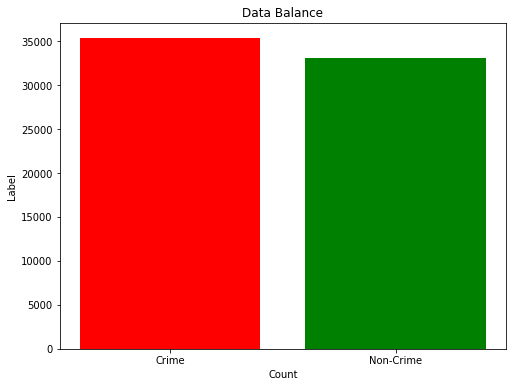

In [10]:
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

In [11]:
def preprocess_x(data, get_word_count = False, single_entry=False):
    text_list = []
    word_count = []

    if not single_entry:
        for entry in data:
            new_text = re.sub("[^a-zA-Z ]", " ", entry)
            new_text = [word for word in new_text.lower().split() if word not in STOPWORDS]
            word_count.append(len(new_text))
            new_text = ' '.join(new_text)
            text_list.append(new_text)
    else:
        new_text = re.sub("[^a-zA-Z ]", " ", data)
        new_text = [word for word in new_text.lower().split() if word not in STOPWORDS]
        word_count.append(len(new_text))
        new_text = ' '.join(new_text)
        text_list.append(new_text)
    
    if get_word_count:
        return text_list, word_count
    else:
        return text_list

In [12]:
filtered_df['text'], filtered_df['word_count'] = preprocess_x(train_df['Title'], get_word_count=True)
filtered_df = filtered_df[filtered_df['text'].map(len)>MIN_WORD_P_ENTRY]

print(filtered_df.head())

                                                text  label  word_count  \
0  villager murdered chhattisgarh police suspect ...      0           7   
1  maha nigerian man wanted drugs case found dead...      0          10   
2           delhi police arrests absconding criminal      0           5   
3            ott show undercover op cop life journey      0           7   
4  internet services suspended days manipur secti...      0           7   

  label_name  
0      Crime  
1      Crime  
2      Crime  
3      Crime  
4      Crime  


Word Count Stats:
count    68393.000000
mean         9.065504
std          2.712731
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         24.000000
Name: word_count, dtype: float64


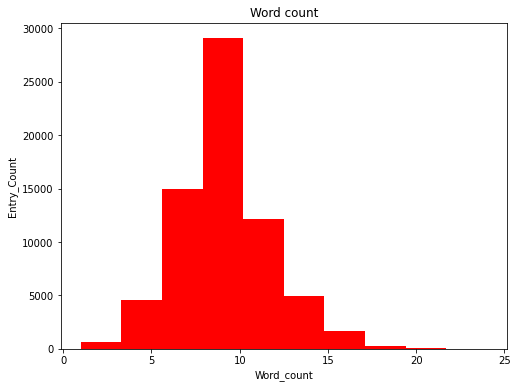

In [13]:
plt.figure(figsize=(8, 6))
print('Word Count Stats:')
print(filtered_df["word_count"].describe())
plt.hist(filtered_df['word_count'],color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [14]:
# filtered_df.to_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime2_filtered.xlsx", index=False)

In [15]:
x_train,x_test,y_train,y_test = train_test_split(filtered_df['text'], filtered_df['label'], test_size=TEST_SIZE,shuffle=True)

In [16]:
def tokenise(tokenizer, data, maxlen=MAX_SEQUENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE):
    data_sequences = tokenizer.texts_to_sequences(data)
    data_padded = pad_sequences(data_sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    return data_padded

In [17]:
tokenizer = Tokenizer(oov_token=OOV_TOK)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

x_train_padded = tokenise(tokenizer, x_train)
x_test_padded = tokenise(tokenizer, x_test)

print(f'Token Count: {len(word_index)}')

Token Count: 32616


In [18]:
MAX_NB_WORDS = len(word_index) + 1

model = Sequential()

model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3261700   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 3,422,902
Trainable params: 3,422,902
Non-trainable params: 0
_________________________________________________________________


In [19]:
optimizer = Adam(learning_rate=LR, decay=DECAY)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

num_epochs = 10
history = model.fit(
    x_train_padded, y_train,
    batch_size=64,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3, min_delta=0.0001, verbose=1)],
    verbose=1)

Epoch 1/10
722/722 [==============================] - 1902s 3s/step - loss: 0.2940 - accuracy: 0.8717 - val_loss: 0.2520 - val_accuracy: 0.8942
Epoch 2/10
722/722 [==============================] - 1912s 3s/step - loss: 0.1674 - accuracy: 0.9349 - val_loss: 0.2572 - val_accuracy: 0.8949
Epoch 3/10
722/722 [==============================] - 1623s 2s/step - loss: 0.1053 - accuracy: 0.9627 - val_loss: 0.2999 - val_accuracy: 0.8893
Epoch 4/10
722/722 [==============================] - 1509s 2s/step - loss: 0.0657 - accuracy: 0.9764 - val_loss: 0.3921 - val_accuracy: 0.8852
Epoch 4: early stopping


In [20]:
accr = model.evaluate(x_test_padded,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

535/535 [==============================] - 136s 254ms/step - loss: 0.3859 - accuracy: 0.8870
Test set
  Loss: 0.386
  Accuracy: 0.887


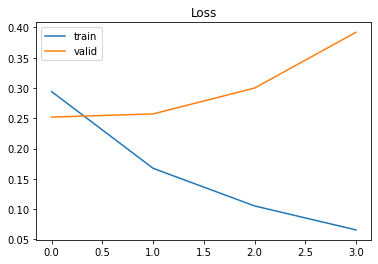

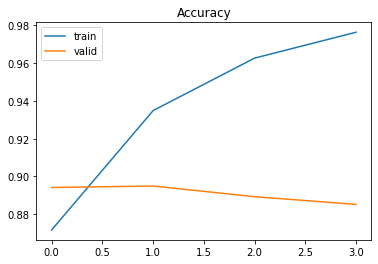

In [21]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show()

In [22]:
complaints = ['25 year man killed over petty argument in Ghat Kopar',
              'Kartik Aaryan-Kiara Adwani Satya Prem ki Katha gets release date',
              'She stole my heart',
              'Man stole 5 sheep for wool']
pre_complaints = preprocess_x(complaints)
padded = tokenise(tokenizer, pre_complaints)
preds = model.predict(padded)
for idx in range(len(preds)):
    print(f'Text: {complaints[idx]}')
    print(f'Label: {label_ids[np.argmax(preds[idx])]}')
    print(f'Confidence: {preds[idx][np.argmax(preds[idx])] * 100}')
    print()

1/1 [==============================] - 3s 3s/step
Text: 25 year man killed over petty argument in Ghat Kopar
Label: Crime
Confidence: 99.99874830245972

Text: Kartik Aaryan-Kiara Adwani Satya Prem ki Katha gets release date
Label: Non-Crime
Confidence: 99.98643398284912

Text: She stole my heart
Label: Crime
Confidence: 93.62927079200745

Text: Man stole 5 sheep for wool
Label: Crime
Confidence: 99.92709755897522

